<a href="https://colab.research.google.com/github/NikhilAdsul977/NeuralNetworkProject/blob/main/TensorFlowTweetTextClassificationV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences





import pydot

In [32]:
from google.colab import drive
drive.mount('/DataSet/')

Mounted at /DataSet/


In [33]:
print(tf.__version__)


2.8.0


In [34]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [35]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



In [36]:
train_data= pd.read_csv("/DataSet/MyDrive/Admission/DataSet/train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['text'] = train_data['text'].apply(remove_emoji)
train_data['text'] = train_data['text'].apply(remove_url)
train_data['text'] = train_data['text'].apply(clean_text)


test_data= pd.read_csv("/DataSet/MyDrive/Admission/DataSet/test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['text'] = test_data['text'].apply(remove_emoji)
test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Train data--------
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64
26752
-------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


-------Test data--------
neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
3434
-------------------------
Train Max Sentence Length :33
Test Max Sentence Length :32


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].tolist())


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

   


[[1, 58, 21, 4]]


In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


Train data len:24076
Class distributionCounter({'neutral': 9633, 'positive': 7537, 'negative': 6906})
Valid data len:2676
Class distributionCounter({'neutral': 1071, 'positive': 838, 'negative': 767})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sh

[  23    4    9   25    2    1   24  823  158    1  173    1 8795 6293
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [40]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['positive', 'positive', 'neutral', 'negative', 'neutral', 'negative', 'positive', 'positive', 'positive', 'neutral']
Text to number
[2 2 1 0 1 0 2 2 2 1]
Number to category
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [41]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

Streaming output truncated to the last 5000 lines.
[  11   66   73 1693    7    9   52  431    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  6 157  28 637   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  85    7   40    6  299  337 1127    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  56 1630    5 5337    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

In [42]:
max_features =20000
embedding_dim =64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 64)            1280064   
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
____________________________________________

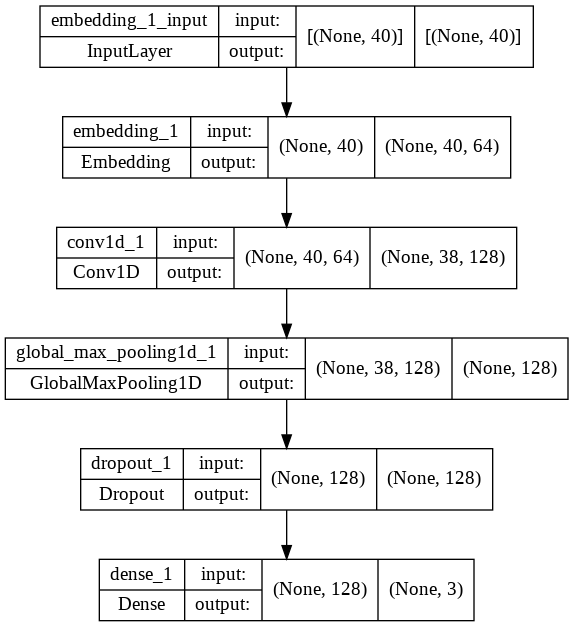

In [43]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [44]:
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


189/189 [==============================] - 3s 12ms/step - loss: 1.0557 - categorical_accuracy: 0.5446 - val_loss: 0.8153 - val_categorical_accuracy: 0.6872
Epoch 2/10
189/189 [==============================] - 2s 11ms/step - loss: 0.7986 - categorical_accuracy: 0.7029 - val_loss: 0.7817 - val_categorical_accuracy: 0.7201
Epoch 3/10
189/189 [==============================] - 2s 11ms/step - loss: 0.7636 - categorical_accuracy: 0.7250 - val_loss: 0.7903 - val_categorical_accuracy: 0.7197
Epoch 4/10
189/189 [==============================] - 2s 11ms/step - loss: 0.7387 - categorical_accuracy: 0.7448 - val_loss: 0.7954 - val_categorical_accuracy: 0.7250
Epoch 5/10
189/189 [==============================] - 2s 11ms/step - loss: 0.7223 - categorical_accuracy: 0.7598 - val_loss: 0.8168 - val_categorical_accuracy: 0.7306
Epoch 6/10
189/189 [==============================] - 2s 11ms/step - loss: 0.7052 - categorical_accuracy: 0.7804 - val_loss: 0.8316 - val_categorical_accuracy: 0.7238
Epoch 7/1

In [45]:
history.history


{'categorical_accuracy': [0.5446087121963501,
  0.702899158000946,
  0.7249958515167236,
  0.7448081374168396,
  0.7598438262939453,
  0.780403733253479,
  0.7912859320640564,
  0.8089383840560913,
  0.8226034045219421,
  0.8382206559181213],
 'loss': [1.0557126998901367,
  0.7985580563545227,
  0.7636473774909973,
  0.7386753559112549,
  0.7223467826843262,
  0.7052292823791504,
  0.6914768218994141,
  0.6783702373504639,
  0.6670001149177551,
  0.6454124450683594],
 'val_categorical_accuracy': [0.6872197389602661,
  0.7201046347618103,
  0.7197309136390686,
  0.7249626517295837,
  0.730567991733551,
  0.7238415479660034,
  0.7272047996520996,
  0.7201046347618103,
  0.7212257385253906,
  0.7193572521209717],
 'val_loss': [0.8152589797973633,
  0.7816621661186218,
  0.7902708649635315,
  0.795404851436615,
  0.8167616724967957,
  0.8316064476966858,
  0.8516495227813721,
  0.8693777322769165,
  0.8915221691131592,
  0.9125869870185852]}

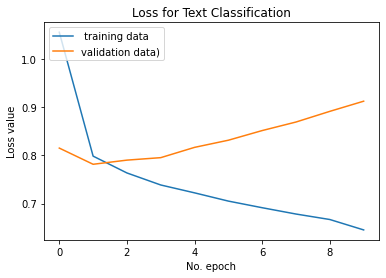

In [46]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

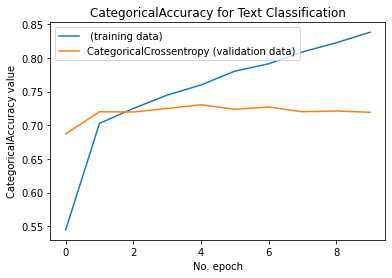

In [47]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [48]:
model.save('/content/sample_data/SACNN.model')
json_string = tokenizer.to_json()

INFO:tensorflow:Assets written to: /content/sample_data/SACNN.model/assets


In [49]:
import json
with open('/content/sample_data/tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [50]:
new_model = tf.keras.models.load_model('/content/sample_data/SACNN.model')
new_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 64)            1280064   
                                                                 
 conv1d_1 (Conv1D)           (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
____________________________________________

In [72]:

sample_seq = tokenizer.texts_to_sequences(['movie was ok'])

sample_input = pad_sequences(sample_seq, padding='post', maxlen=40)

sample_pred = new_model.predict(sample_input)

sample_pred_argmx = sample_pred.argmax(axis=-1)

print(sample_pred_argmx)
print(sample_pred)

[1]
[[0.3744422  0.74733394 0.31233394]]
